In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [2]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.1" 2021-10-19; OpenJDK Runtime Environment Temurin-17.0.1+12 (build 17.0.1+12); OpenJDK 64-Bit Server VM Temurin-17.0.1+12 (build 17.0.1+12, mixed mode)
  Starting server from /Users/per-christian/opt/anaconda3/envs/tdt4173/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/2p/72g9pz790kb771nk16cvz7dr0000gn/T/tmp43kn_5iw
  JVM stdout: /var/folders/2p/72g9pz790kb771nk16cvz7dr0000gn/T/tmp43kn_5iw/h2o_per_christian_started_from_python.out
  JVM stderr: /var/folders/2p/72g9pz790kb771nk16cvz7dr0000gn/T/tmp43kn_5iw/h2o_per_christian_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.1
H2O_cluster_version_age:,9 days
H2O_cluster_name:,H2O_from_python_per_christian_9i38xg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [3]:
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

In [4]:
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')


In [5]:
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')



In [6]:
X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')


In [7]:
x_train_merged_a = pd.concat([X_train_observed_a,X_train_estimated_a])
x_train_merged_b = pd.concat([X_train_observed_b,X_train_estimated_b])
x_train_merged_c = pd.concat([X_train_observed_c,X_train_estimated_c])

In [8]:
# Calculating from 15-minute intervals to hourly intervals based on different aggregation methods
def resample_to_hourly(df, aggregation_methods):
    df_hourly = df.resample('H', on = 'date_forecast').agg(aggregation_methods)
    df_hourly.reset_index(inplace=True)
    return df_hourly

# Aggregation methods based on features' names
aggregation_methods = {
    'date_calc' : 'max',
    'absolute_humidity_2m:gm3': 'mean',
    'air_density_2m:kgm3': 'mean',
    'ceiling_height_agl:m': 'mean',
    'clear_sky_energy_1h:J': 'sum',
    'clear_sky_rad:W': 'mean',
    'cloud_base_agl:m': 'mean',
    'dew_or_rime:idx': 'max',
    'dew_point_2m:K': 'mean',
    'diffuse_rad:W': 'mean',
    'diffuse_rad_1h:J': 'sum',
    'direct_rad:W': 'mean',
    'direct_rad_1h:J': 'sum',
    'effective_cloud_cover:p': 'mean',
    'elevation:m': 'mean',
    'fresh_snow_12h:cm': 'sum',
    'fresh_snow_1h:cm': 'sum',
    'fresh_snow_24h:cm': 'sum',
    'fresh_snow_3h:cm': 'sum',
    'fresh_snow_6h:cm': 'sum',
    'is_day:idx': 'max',
    'is_in_shadow:idx': 'max',
    'msl_pressure:hPa': 'mean',
    'precip_5min:mm': 'sum',
    'precip_type_5min:idx': 'max',
    'pressure_100m:hPa': 'mean',
    'pressure_50m:hPa': 'mean',
    'prob_rime:p': 'mean',
    'rain_water:kgm2': 'sum',
    'relative_humidity_1000hPa:p': 'mean',
    'sfc_pressure:hPa': 'mean',
    'snow_density:kgm3': 'mean',
    'snow_depth:cm': 'mean',
    'snow_drift:idx': 'max',
    'snow_melt_10min:mm': 'sum',
    'snow_water:kgm2': 'sum',
    'sun_azimuth:d': 'mean',
    'sun_elevation:d': 'mean',
    'super_cooled_liquid_water:kgm2': 'mean',
    't_1000hPa:K': 'mean',
    'total_cloud_cover:p': 'mean',
    'visibility:m': 'mean',
    'wind_speed_10m:ms': 'mean',
    'wind_speed_u_10m:ms': 'mean',
    'wind_speed_v_10m:ms': 'mean',
    'wind_speed_w_1000hPa:ms': 'mean'
}


In [9]:
# Apply the function to each dataset
x_train_a_hourly = resample_to_hourly(x_train_merged_a, aggregation_methods)
x_train_b_hourly = resample_to_hourly(x_train_merged_b, aggregation_methods)
x_train_c_hourly = resample_to_hourly(x_train_merged_c, aggregation_methods)

x_test_a_hourly = resample_to_hourly(X_test_estimated_a, aggregation_methods)
x_test_b_hourly = resample_to_hourly(X_test_estimated_b, aggregation_methods)
x_test_c_hourly = resample_to_hourly(X_test_estimated_c, aggregation_methods)

In [10]:
# Remove all rows with date-time values that are not present in both x and y in order to synchronize x and its labels. 
def remove_non_synchronous_rows(x_train, y_train, x_date_column='date_forecast', y_date_column='time'):
    # Convert date columns to datetime format for easier comparison
    x_train[x_date_column] = pd.to_datetime(x_train[x_date_column])
    y_train[y_date_column] = pd.to_datetime(y_train[y_date_column])
    
    # Find common dates
    common_dates = x_train[x_date_column][x_train[x_date_column].isin(y_train[y_date_column])]
    
    # Filter both datasets based on common dates
    x_train_synced = x_train[x_train[x_date_column].isin(common_dates)]
    y_train_synced = y_train[y_train[y_date_column].isin(common_dates)]
    
    return x_train_synced, y_train_synced


In [11]:
# Remove the rows with date and time that only shows up in one of the sets
x_train_a_hourly, train_a = remove_non_synchronous_rows(x_train_a_hourly, train_a)
x_train_b_hourly, train_b = remove_non_synchronous_rows(x_train_b_hourly, train_b)
x_train_c_hourly, train_c = remove_non_synchronous_rows(x_train_c_hourly, train_c)

In [12]:
    
test = pd.read_csv('test.csv')
pred_time_stamps = test['time'].unique()
x_test_a_hourly = x_test_a_hourly[x_test_a_hourly['date_forecast'].isin(pred_time_stamps)]
x_test_b_hourly = x_test_b_hourly[x_test_b_hourly['date_forecast'].isin(pred_time_stamps)]
x_test_c_hourly = x_test_c_hourly[x_test_c_hourly['date_forecast'].isin(pred_time_stamps)]


In [13]:
#Create time-based features for hour,day, month
def add_time_feat(X):
    X_frame = X.copy().set_index('date_forecast')
    X_frame['year'] = X_frame.index.year
    X_frame['month'] = X_frame.index.month
    X_frame['day'] = X_frame.index.day
    X_frame['hour'] = X_frame.index.hour
    return X_frame

In [14]:
#Make categorical variable of date_calc
X_train_a = add_time_feat(x_train_a_hourly).drop(columns = ['date_calc'])
X_test_a = add_time_feat(x_test_a_hourly).drop(columns = ['date_calc'])

X_train_b = add_time_feat(x_train_b_hourly).drop(columns = ['date_calc'])
X_test_b = add_time_feat(x_test_b_hourly).drop(columns = ['date_calc'])

X_train_c = add_time_feat(x_train_c_hourly).drop(columns = ['date_calc'])
X_test_c = add_time_feat(x_test_c_hourly).drop(columns = ['date_calc'])

In [21]:
from h2o.automl import H2OAutoML

def build_model(X_train,y_train,location):
    merged_data = X_train.copy()
    merged_data['pv_measurement'] = y_train['pv_measurement'].values
    
    y = 'pv_measurement'
    x = list(X_train.columns)
    train = h2o.H2OFrame(merged_data)
    
    aml = H2OAutoML(
        max_models = 10,
        max_runtime_secs = 60,
        exclude_algos =['DeepLearning'],
        seed = 1,
        # stopping_metric ='logloss',
        sort_metric ='mae',
        balance_classes = False,
        project_name = location
    )

    aml.train(x=x, y=y, training_frame=train)
    
    lb = aml.leaderboard
    leader = aml.leader
    print(lb.head(rows=lb.nrows))
    
    #h2o.save_model(leader, path=f'Saved_models/{location.upper()}', force = True)

    return lb,leader

In [16]:
X_train_c

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,year,month,day,hour
date_forecast,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,5.475,1.24075,1130.025024,0.000000,0.000,1130.025024,1.0,274.975006,0.000,0.000000,0.0,0.000000,78.699997,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,986.949951,0.18,1.0,972.150024,978.174988,0.20,0.0,89.949997,984.250000,NaN,0.0,0.0,0.0,0.2,20.734001,-48.355999,0.000,278.350006,83.824997,16509.250000,2.900,1.125,2.625,0.0,2019,1,1,0
2019-01-01 01:00:00,5.350,1.24000,1066.674927,0.000000,0.000,1066.674927,1.0,274.649994,0.000,0.000000,0.0,0.000000,97.375000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,986.174988,0.06,1.0,971.250000,977.299988,0.15,0.0,89.000000,983.375000,NaN,0.0,0.0,0.0,0.4,40.327751,-44.950500,0.000,278.200012,99.074997,13277.525391,3.650,1.425,3.350,0.0,2019,1,1,1
2019-01-01 02:00:00,5.350,1.23900,1002.349976,0.000000,0.000,1002.349976,0.0,274.649994,0.000,0.000000,0.0,0.000000,95.900002,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,985.974976,0.00,0.0,971.075012,977.099976,0.00,0.0,87.699997,983.174988,NaN,0.0,0.0,0.0,0.4,57.828251,-39.885750,0.100,278.149994,97.650002,11213.525391,3.950,1.900,3.475,0.0,2019,1,1,2
2019-01-01 03:00:00,5.300,1.24000,959.150024,0.000000,0.000,959.150024,0.0,274.475006,0.000,0.000000,0.0,0.000000,96.074997,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,986.299988,0.18,1.0,971.349976,977.450012,0.00,0.0,88.949997,983.549988,NaN,0.0,0.0,0.0,0.3,73.391998,-33.781502,0.200,277.625000,96.625000,7082.125000,4.600,3.025,3.400,0.0,2019,1,1,3
2019-01-01 04:00:00,5.625,1.23825,952.349976,0.000000,0.000,952.349976,0.0,275.299988,0.000,0.000000,0.0,0.000000,96.925003,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,986.900024,0.06,1.0,971.900024,978.000000,0.00,0.0,92.750000,984.025024,NaN,0.0,0.0,0.0,0.4,87.531754,-27.170500,0.200,277.500000,96.974998,5347.424805,5.425,4.925,2.175,0.0,2019,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30 19:00:00,4.400,1.27550,1456.574951,336040.593750,4.175,551.224976,0.0,272.024994,2.775,219096.000000,0.0,39738.300781,97.724998,24.0,0.0,0.0,1.2,0.0,0.0,1.0,1.0,1014.900024,0.00,0.0,999.049988,1005.275024,0.00,0.0,74.800003,1011.525024,NaN,0.0,0.0,0.0,0.0,304.936493,-0.201500,0.000,274.924988,97.724998,25028.000000,4.075,3.600,1.875,0.0,2023,4,30,19
2023-04-30 20:00:00,4.400,1.27850,1476.349976,8827.200195,0.000,564.099976,0.0,271.950012,0.000,19936.199219,0.0,0.000000,95.449997,24.0,0.0,0.0,1.2,0.0,0.0,0.0,1.0,1014.849976,0.00,0.0,999.025024,1005.250000,0.00,0.0,76.974998,1011.549988,NaN,0.0,0.0,0.0,0.0,318.620483,-5.204000,0.000,274.575012,95.850006,23995.599609,3.600,2.950,2.125,0.0,2023,4,30,20
2023-04-30 21:00:00,4.400,1.27900,1516.300049,0.000000,0.000,578.700012,0.0,271.899994,0.000,0.000000,0.0,0.000000,93.925003,24.0,0.0,0.0,1.2,0.0,0.0,0.0,1.0,1014.650024,0.00,0.0,998.900024,1005.125000,0.00,0.0,77.724998,1011.400024,NaN,0.0,0.0,0.0,0.0,332.780243,-8.984500,0.025,274.399994,95.925003,23068.599609,3.600,2.625,2.400,0.0,2023,4,30,21


In [17]:
x_train_a1 = pd.read_csv('cleaned_data/A/x_train_a.csv')
x_train_b1 = pd.read_csv('cleaned_data/B/x_train_b.csv')
x_train_c1 = pd.read_csv('cleaned_data/C/x_train_c.csv')

x_test_a1 = pd.read_csv('cleaned_data/A/x_test_a.csv')
x_test_b1 = pd.read_csv('cleaned_data/B/x_test_b.csv')
x_test_c1 = pd.read_csv('cleaned_data/C/x_test_c.csv')

y_train_a1 = pd.read_csv('cleaned_data/A/train_a.csv')
y_train_b1 = pd.read_csv('cleaned_data/B/train_b.csv')
y_train_c1 = pd.read_csv('cleaned_data/C/train_c.csv')

In [18]:
x_train_c1

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,forecast_year,forecast_month,forecast_day,forecast_hour,calc_year,calc_month,calc_day,calc_hour
0,6.625,1.22075,2287.250,5283377.5,421.225,2287.250,0.0,278.20000,67.975,932039.7,338.15000,4189764.0,15.575000,24.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1009.075,0.0,0.0,993.55005,999.55005,0.0,0.0,60.650,1005.55005,NaN,0.0,0.0,0.0,0.0,130.353500,25.75500,0.000,283.72500,31.199999,49549.450,1.250,-0.825,0.825,0.0,2019,9,4,8,NaN,NaN,NaN,NaN
1,6.275,1.21425,2679.075,6726922.0,508.125,2679.075,0.0,277.42500,76.625,1041404.3,406.05000,5358227.0,43.100000,24.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1007.950,0.0,0.0,992.57500,998.52500,0.0,0.0,53.300,1004.50000,NaN,0.0,0.0,0.0,0.0,146.494500,30.20425,0.000,284.80000,86.250000,52309.977,1.500,-1.500,-0.200,0.0,2019,9,4,9,NaN,NaN,NaN,NaN
2,5.900,1.20825,2983.750,7747199.5,561.875,2983.750,0.0,276.65002,112.575,1362371.1,399.70000,5801325.0,47.574997,24.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1007.025,0.0,0.0,991.67500,997.60000,0.0,0.0,47.300,1003.55000,NaN,0.0,0.0,0.0,0.0,163.708250,33.02750,0.000,285.90000,95.149994,53978.800,2.000,-2.000,-0.225,0.0,2019,9,4,10,NaN,NaN,NaN,NaN
3,5.875,1.20350,3286.550,8254105.0,578.025,3286.550,0.0,276.65000,195.150,2215590.5,272.69998,4841281.0,50.000000,24.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1006.250,0.0,0.0,990.94995,996.85000,0.0,0.0,43.450,1002.77500,NaN,0.0,0.0,0.0,0.0,181.566740,33.88700,0.000,286.92500,100.000000,54510.926,1.950,-1.950,-0.250,0.0,2019,9,4,11,NaN,NaN,NaN,NaN
4,6.150,1.20175,3453.425,8205280.0,555.175,3453.425,0.0,277.25000,243.375,3157120.2,112.35000,2772411.0,59.425000,24.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1005.400,0.0,0.0,990.17500,996.05000,0.0,0.0,44.025,1002.00000,NaN,0.0,0.0,0.0,0.2,199.359010,32.66900,0.000,287.50000,100.000000,54284.650,1.525,-1.500,-0.300,0.0,2019,9,4,12,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26090,4.400,1.27550,1456.575,336040.6,4.175,551.225,0.0,272.02500,2.775,219096.0,0.00000,39738.3,97.725000,24.0,0.0,0.0,1.2,0.0,0.0,1.0,1.0,1014.900,0.0,0.0,999.05000,1005.27500,0.0,0.0,74.800,1011.52500,NaN,0.0,0.0,0.0,0.0,304.936500,-0.20150,0.000,274.92500,97.725000,25028.000,4.075,3.600,1.875,0.0,2023,4,30,19,2023.0,4.0,29.0,7.0
26091,4.400,1.27850,1476.350,8827.2,0.000,564.100,0.0,271.95000,0.000,19936.2,0.00000,0.0,95.450000,24.0,0.0,0.0,1.2,0.0,0.0,0.0,1.0,1014.850,0.0,0.0,999.02500,1005.25000,0.0,0.0,76.975,1011.55000,NaN,0.0,0.0,0.0,0.0,318.620480,-5.20400,0.000,274.57500,95.850006,23995.600,3.600,2.950,2.125,0.0,2023,4,30,20,2023.0,4.0,29.0,7.0
26092,4.400,1.27900,1516.300,0.0,0.000,578.700,0.0,271.90000,0.000,0.0,0.00000,0.0,93.925000,24.0,0.0,0.0,1.2,0.0,0.0,0.0,1.0,1014.650,0.0,0.0,998.90000,1005.12500,0.0,0.0,77.725,1011.40000,NaN,0.0,0.0,0.0,0.0,332.780240,-8.98450,0.025,274.40000,95.925000,23068.600,3.600,2.625,2.400,0.0,2023,4,30,21,2023.0,4.0,29.0,7.0
26093,4.400,1.27975,1240.600,0.0,0.000,551.500,0.0,271.95000,0.000,0.0,0.00000,0.0,98.375000,24.0,0.0,0.0,1.2,0.0,0.0,0.0,1.0,1014.500,0.0,0.0,998.72500,1004.97500,0.0,0.0,79.400,1011.22500,NaN,0.0,0.0,0.0,0.3,347.373230,-1

In [20]:
X_train_c

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,year,month,day,hour
date_forecast,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,5.475,1.24075,1130.025024,0.000000,0.000,1130.025024,1.0,274.975006,0.000,0.000000,0.0,0.000000,78.699997,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,986.949951,0.18,1.0,972.150024,978.174988,0.20,0.0,89.949997,984.250000,NaN,0.0,0.0,0.0,0.2,20.734001,-48.355999,0.000,278.350006,83.824997,16509.250000,2.900,1.125,2.625,0.0,2019,1,1,0
2019-01-01 01:00:00,5.350,1.24000,1066.674927,0.000000,0.000,1066.674927,1.0,274.649994,0.000,0.000000,0.0,0.000000,97.375000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,986.174988,0.06,1.0,971.250000,977.299988,0.15,0.0,89.000000,983.375000,NaN,0.0,0.0,0.0,0.4,40.327751,-44.950500,0.000,278.200012,99.074997,13277.525391,3.650,1.425,3.350,0.0,2019,1,1,1
2019-01-01 02:00:00,5.350,1.23900,1002.349976,0.000000,0.000,1002.349976,0.0,274.649994,0.000,0.000000,0.0,0.000000,95.900002,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,985.974976,0.00,0.0,971.075012,977.099976,0.00,0.0,87.699997,983.174988,NaN,0.0,0.0,0.0,0.4,57.828251,-39.885750,0.100,278.149994,97.650002,11213.525391,3.950,1.900,3.475,0.0,2019,1,1,2
2019-01-01 03:00:00,5.300,1.24000,959.150024,0.000000,0.000,959.150024,0.0,274.475006,0.000,0.000000,0.0,0.000000,96.074997,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,986.299988,0.18,1.0,971.349976,977.450012,0.00,0.0,88.949997,983.549988,NaN,0.0,0.0,0.0,0.3,73.391998,-33.781502,0.200,277.625000,96.625000,7082.125000,4.600,3.025,3.400,0.0,2019,1,1,3
2019-01-01 04:00:00,5.625,1.23825,952.349976,0.000000,0.000,952.349976,0.0,275.299988,0.000,0.000000,0.0,0.000000,96.925003,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,986.900024,0.06,1.0,971.900024,978.000000,0.00,0.0,92.750000,984.025024,NaN,0.0,0.0,0.0,0.4,87.531754,-27.170500,0.200,277.500000,96.974998,5347.424805,5.425,4.925,2.175,0.0,2019,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30 19:00:00,4.400,1.27550,1456.574951,336040.593750,4.175,551.224976,0.0,272.024994,2.775,219096.000000,0.0,39738.300781,97.724998,24.0,0.0,0.0,1.2,0.0,0.0,1.0,1.0,1014.900024,0.00,0.0,999.049988,1005.275024,0.00,0.0,74.800003,1011.525024,NaN,0.0,0.0,0.0,0.0,304.936493,-0.201500,0.000,274.924988,97.724998,25028.000000,4.075,3.600,1.875,0.0,2023,4,30,19
2023-04-30 20:00:00,4.400,1.27850,1476.349976,8827.200195,0.000,564.099976,0.0,271.950012,0.000,19936.199219,0.0,0.000000,95.449997,24.0,0.0,0.0,1.2,0.0,0.0,0.0,1.0,1014.849976,0.00,0.0,999.025024,1005.250000,0.00,0.0,76.974998,1011.549988,NaN,0.0,0.0,0.0,0.0,318.620483,-5.204000,0.000,274.575012,95.850006,23995.599609,3.600,2.950,2.125,0.0,2023,4,30,20
2023-04-30 21:00:00,4.400,1.27900,1516.300049,0.000000,0.000,578.700012,0.0,271.899994,0.000,0.000000,0.0,0.000000,93.925003,24.0,0.0,0.0,1.2,0.0,0.0,0.0,1.0,1014.650024,0.00,0.0,998.900024,1005.125000,0.00,0.0,77.724998,1011.400024,NaN,0.0,0.0,0.0,0.0,332.780243,-8.984500,0.025,274.399994,95.925003,23068.599609,3.600,2.625,2.400,0.0,2023,4,30,21


In [25]:
y_train_c1

,pv_measurement,time_year,time_month,time_day,time_hour
0,137.20,2019,9,4,8
1,0.00,2019,9,4,9
2,0.00,2019,9,4,10
3,0.00,2019,9,4,11
4,0.00,2019,9,4,12
...,...,...,...,...,...
26090,50.96,2023,4,30,19
26091,2.94,2023,4,30,20
26092,0.00,2023,4,30,21
26093,-0.00,2023,4,30,22


In [31]:
lb_a,model_a = build_model(x_train_a1,y_train_a1,'A')
lb_b,model_b = build_model(x_train_b1,y_train_b1,'B')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
20:33:27.348: AutoML: XGBoost is not available; skipping it.
20:33:27.350: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

██████████████████
20:33:43.58: XRT_1_AutoML_4_20231025_203327 [DRF XRT (Extremely Randomized Trees)] failed: java.lang.AssertionError

█████████████████████████████████████████████| (done) 100%
model_id                                                     mae     rmse     mse       rmsle    mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_4_20231025_203327     177.861  386.926  149711  nan                           149711
GBM_4_AutoML_4_20231025_203327                           178.471  395.988  156806  nan                           156806
StackedEnsemble_BestOfFamily_1_AutoML_4_20231025_203327  180.94   396.7    157371  nan                           157371
GBM_grid_1_AutoML_4_20231025_203327_model_1             

In [27]:

lb_c,model_c = build_model(x_train_c1,y_train_c1,'C1')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
20:28:49.487: AutoML: XGBoost is not available; skipping it.
20:28:49.490: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

████████████
20:29:00.648: XRT_1_AutoML_3_20231025_202849 [DRF XRT (Extremely Randomized Trees)] failed: java.lang.AssertionError

███████████████████████████████████████████████████| (done) 100%
model_id                                                     mae     rmse      mse       rmsle    mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_3_20231025_202849     21.6093  52.6742  2774.57  nan                          2774.57
GBM_grid_1_AutoML_3_20231025_202849_model_1              21.7423  53.5558  2868.22  nan                          2868.22
GBM_4_AutoML_3_20231025_202849                           22.077   53.5965  2872.59  nan                          2872.59
StackedEnsemble_BestOfFamily_1_AutoML_3_20231025_20

In [ ]:
lb_a,model_a = build_model(X_train_a,train_a,'A')
lb_b,model_b = build_model(X_train_b,train_b,'B')
lb_c,model_c = build_model(X_train_c,train_c,'C')

In [32]:
preds_a = model_a.predict(h2o.H2OFrame(X_test_a))
preds_b = model_b.predict(h2o.H2OFrame(X_test_b))
preds_c = model_c.predict(h2o.H2OFrame(X_test_c))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |

/Users/per-christian/opt/anaconda3/envs/tdt4173/lib/python3.9/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'forecast_year': substituting in a column of NaN
  warnings.warn(w)
/Users/per-christian/opt/anaconda3/envs/tdt4173/lib/python3.9/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'forecast_month': substituting in a column of NaN
  warnings.warn(w)
/Users/per-christian/opt/anaconda3/envs/tdt4173/lib/python3.9/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'forecast_day': substituting in a column of NaN
  warnings.warn(w)
/Users/per-christian/opt/anaconda3/envs/tdt4173/lib/python3.9/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'forecast_hour': substituting in a column of NaN
  warnings.warn(w)
/Users/per-christian/opt/anaconda3/envs/tdt4173/lib/python3.9/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing colum

████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [34]:
model_a_first = h2o.load_model('Saved_models/A/GBM_4_AutoML_1_20231020_170352')
model_b_first = h2o.load_model('Saved_models/B/GBM_8_AutoML_2_20231020_170654')
model_c_first = h2o.load_model('Saved_models/C/GBM_8_AutoML_2_20231020_170654')

H2OResponseError: Server error java.lang.IllegalArgumentException:
  Error: Found version 3.42.0.4, but running version 3.44.0.1

For more information visit:
  https://github.com/h2oai/h2o-3/discussions/15523
  Request: POST /99/Models.bin/
    data: {'dir': 'Saved_models/A/GBM_4_AutoML_1_20231020_170352'}


In [30]:
preds_a_original = model_a_first.predict(h2o.H2OFrame(X_test_a))
preds_b_original = model_b_first.predict(h2o.H2OFrame(X_test_b))
preds_c_original = model_c_first.predict(h2o.H2OFrame(X_test_c))

NameError: name 'model_a_first' is not defined

In [ ]:
def compare_two_preds(pred1,pred2):
    pred1 = preds_a_original.as_data_frame()
    pred2 = preds_a2.as_data_frame()

    plt.figure(figsize=(10, 8))

    # Scatter plot
    plt.scatter(y_pred1['predict'], y_pred2['predict'], alpha=0.5)

    # Line of equality (for reference)
    plt.plot([y_pred1['predict'].min(), y_pred1['predict'].max()],
             [y_pred2['predict'].min(), y_pred2['predict'].max()],
             color='red', linestyle='--')

    # Labels and title
    plt.xlabel('Predictions from First Model')
    plt.ylabel('Predictions from New model')
    plt.title('Comparison of Predictions from Two Models')

    # Show plot
    plt.grid(True)
    plt.show()

In [ ]:
compare_two_preds(preds_a,preds_a_original)

In [35]:
# 2. Feature Importance
def feat_importance(model, n_feats):
    feature_importance = model.varimp(use_pandas=True)
    n_top_feats = feature_importance.iloc[:n_feats,:]
    return n_top_feats

print(feat_importance(model_a, 15))

AttributeError: 'NoneType' object has no attribute 'iloc'

In [39]:
def plot_prediction(preds):
    predictions= preds['predict'].as_data_frame()
    predictions['time'] = test['time'].unique()
    fig, ax1 = plt.subplots(figsize=(15, 6))
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Prediction', color='tab:blue')
    ax1.plot(predictions['time'], predictions['predict'], color='tab:blue', label='Solar Power Production')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    fig.tight_layout()
    plt.title(f'Time Series Plot of prediction')
    plt.show()

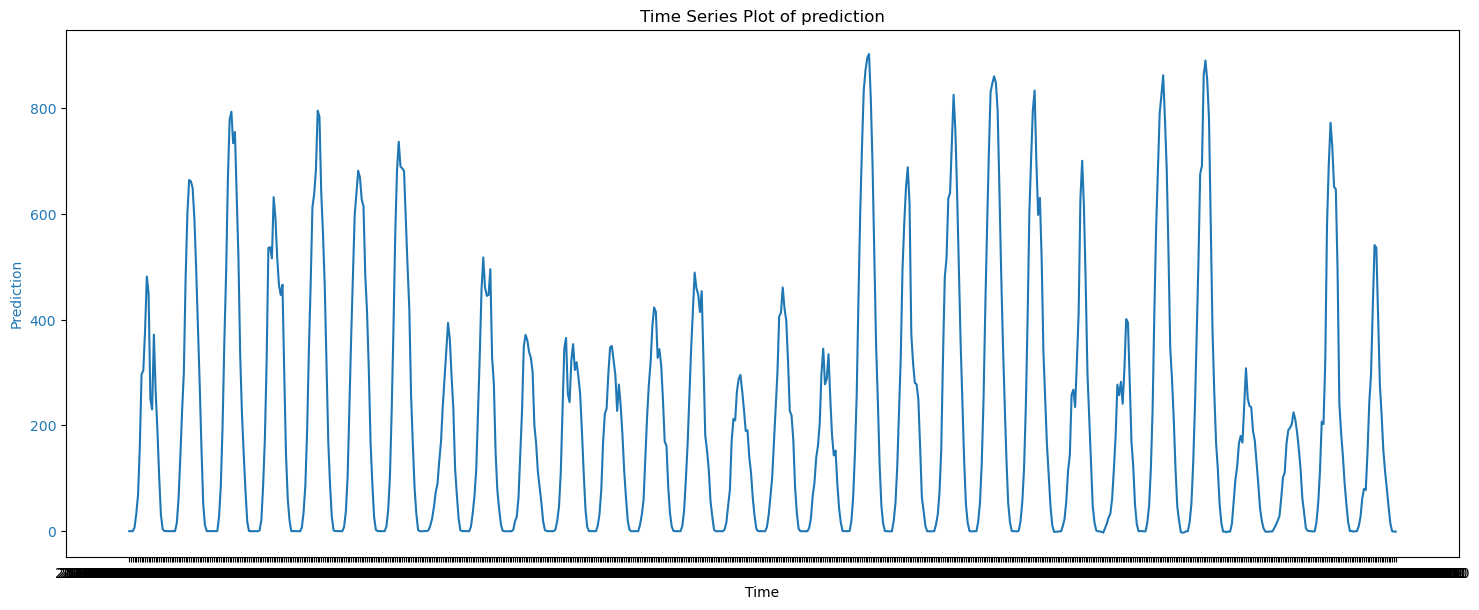

In [43]:
plot_prediction(preds_c)

In [ ]:
plot_prediction(preds_c_original)

In [44]:
def create_sub(preds_a,preds_b,preds_c):
    submission = pd.read_csv('sample_submission.csv')
    predictions = preds_a.rbind(preds_b).rbind(preds_c)
    predictions_df = predictions['predict'].as_data_frame()
    predictions_df.loc[predictions_df['predict'] < 0, 'predict'] = 0
    submission['prediction'] = predictions_df['predict']
    return submission 


In [45]:
sub1 = create_sub(preds_a,preds_b,preds_c)
sub1.to_csv(f'Submissions/HenningDS.csv', index=False)